In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*
plt.style.use('seaborn')
plt.rcParams.update(edog.plot.params)

filename = "params.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])
A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])

w_rc_ex, A_rc_ex, a_rc_ex = itemgetter("w", "A", "a")(params["relay"]["Krc_ex"])
w_rc_ex_fix, a_rc_ex_fix = itemgetter("w_fix", "a_fix")(params["relay"]["Krc_ex"])

w_rc_in, A_rc_in, a_rc_in = itemgetter("w", "A", "a")(params["relay"]["Krc_in"])
w_rc_in_fix, a_rc_in_fix = itemgetter("w_fix", "a_fix")(params["relay"]["Krc_in"])

irf_data = {"ff_ex": {}, "widths": {}, "weights": {}}

## Feedforward excitation

In [3]:
network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                         A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                         w_rg=w_rg, A_rg=A_rg, a_rg=a_rg)

[relay] = get_neuron("Relay", network)
network.compute_irf(relay)
spatial_irf = relay.irf[0, :, :]
positions = network.integrator.positions

cen_ex, sur_in, cen_size = spatial_irf_params(spatial_irf, positions)
irf_data["ff_ex"] = {"cen_ex": cen_ex, "sur_in": sur_in, "cen_size": cen_size}

## Feedback widths

In [4]:
cen_ex = np.zeros([len(a_rc_in), len(a_rc_ex)])
sur_in = np.zeros([len(a_rc_in), len(a_rc_ex)])
cen_size = np.zeros([len(a_rc_in), len(a_rc_ex)])

for i, a_in in enumerate(a_rc_in):
    for j, a_ex in enumerate(a_rc_ex):
        network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                 A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                 w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                 w_rc_ex=w_rc_ex_fix, A_rc_ex=A_rc_ex, a_rc_ex=a_ex,
                                 w_rc_in=w_rc_in_fix, A_rc_in=A_rc_in, a_rc_in=a_in)
        
        [relay] = get_neuron("Relay", network)
        network.compute_irf(relay)
        spatial_irf = relay.irf[0, :, :]
        positions = network.integrator.positions

        cen_ex[i, j], sur_in[i, j], cen_size[i, j] = spatial_irf_params(spatial_irf, positions)

irf_data["widths"] = {"cen_ex": cen_ex, "sur_in": sur_in, "cen_size": cen_size}

## Feedback weights

In [5]:
cen_ex = np.zeros([len(w_rc_in), len(w_rc_ex)])
sur_in = np.zeros([len(w_rc_in), len(w_rc_ex)])
cen_size = np.zeros([len(w_rc_in), len(w_rc_ex)])

for i, w_in in enumerate(w_rc_in):
    for j, w_ex in enumerate(w_rc_ex):
        network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                 A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                 w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                 w_rc_ex=w_ex, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex_fix,
                                 w_rc_in=w_in, A_rc_in=A_rc_in, a_rc_in=a_rc_in_fix)
        
        [relay] = get_neuron("Relay", network)
        network.compute_irf(relay)
        spatial_irf = relay.irf[0, :, :]
        positions = network.integrator.positions

        cen_ex[i, j], sur_in[i, j], cen_size[i, j] = spatial_irf_params(spatial_irf, positions)

irf_data["weights"] = {"cen_ex": cen_ex, "sur_in": sur_in, "cen_size": cen_size}

## Plotting


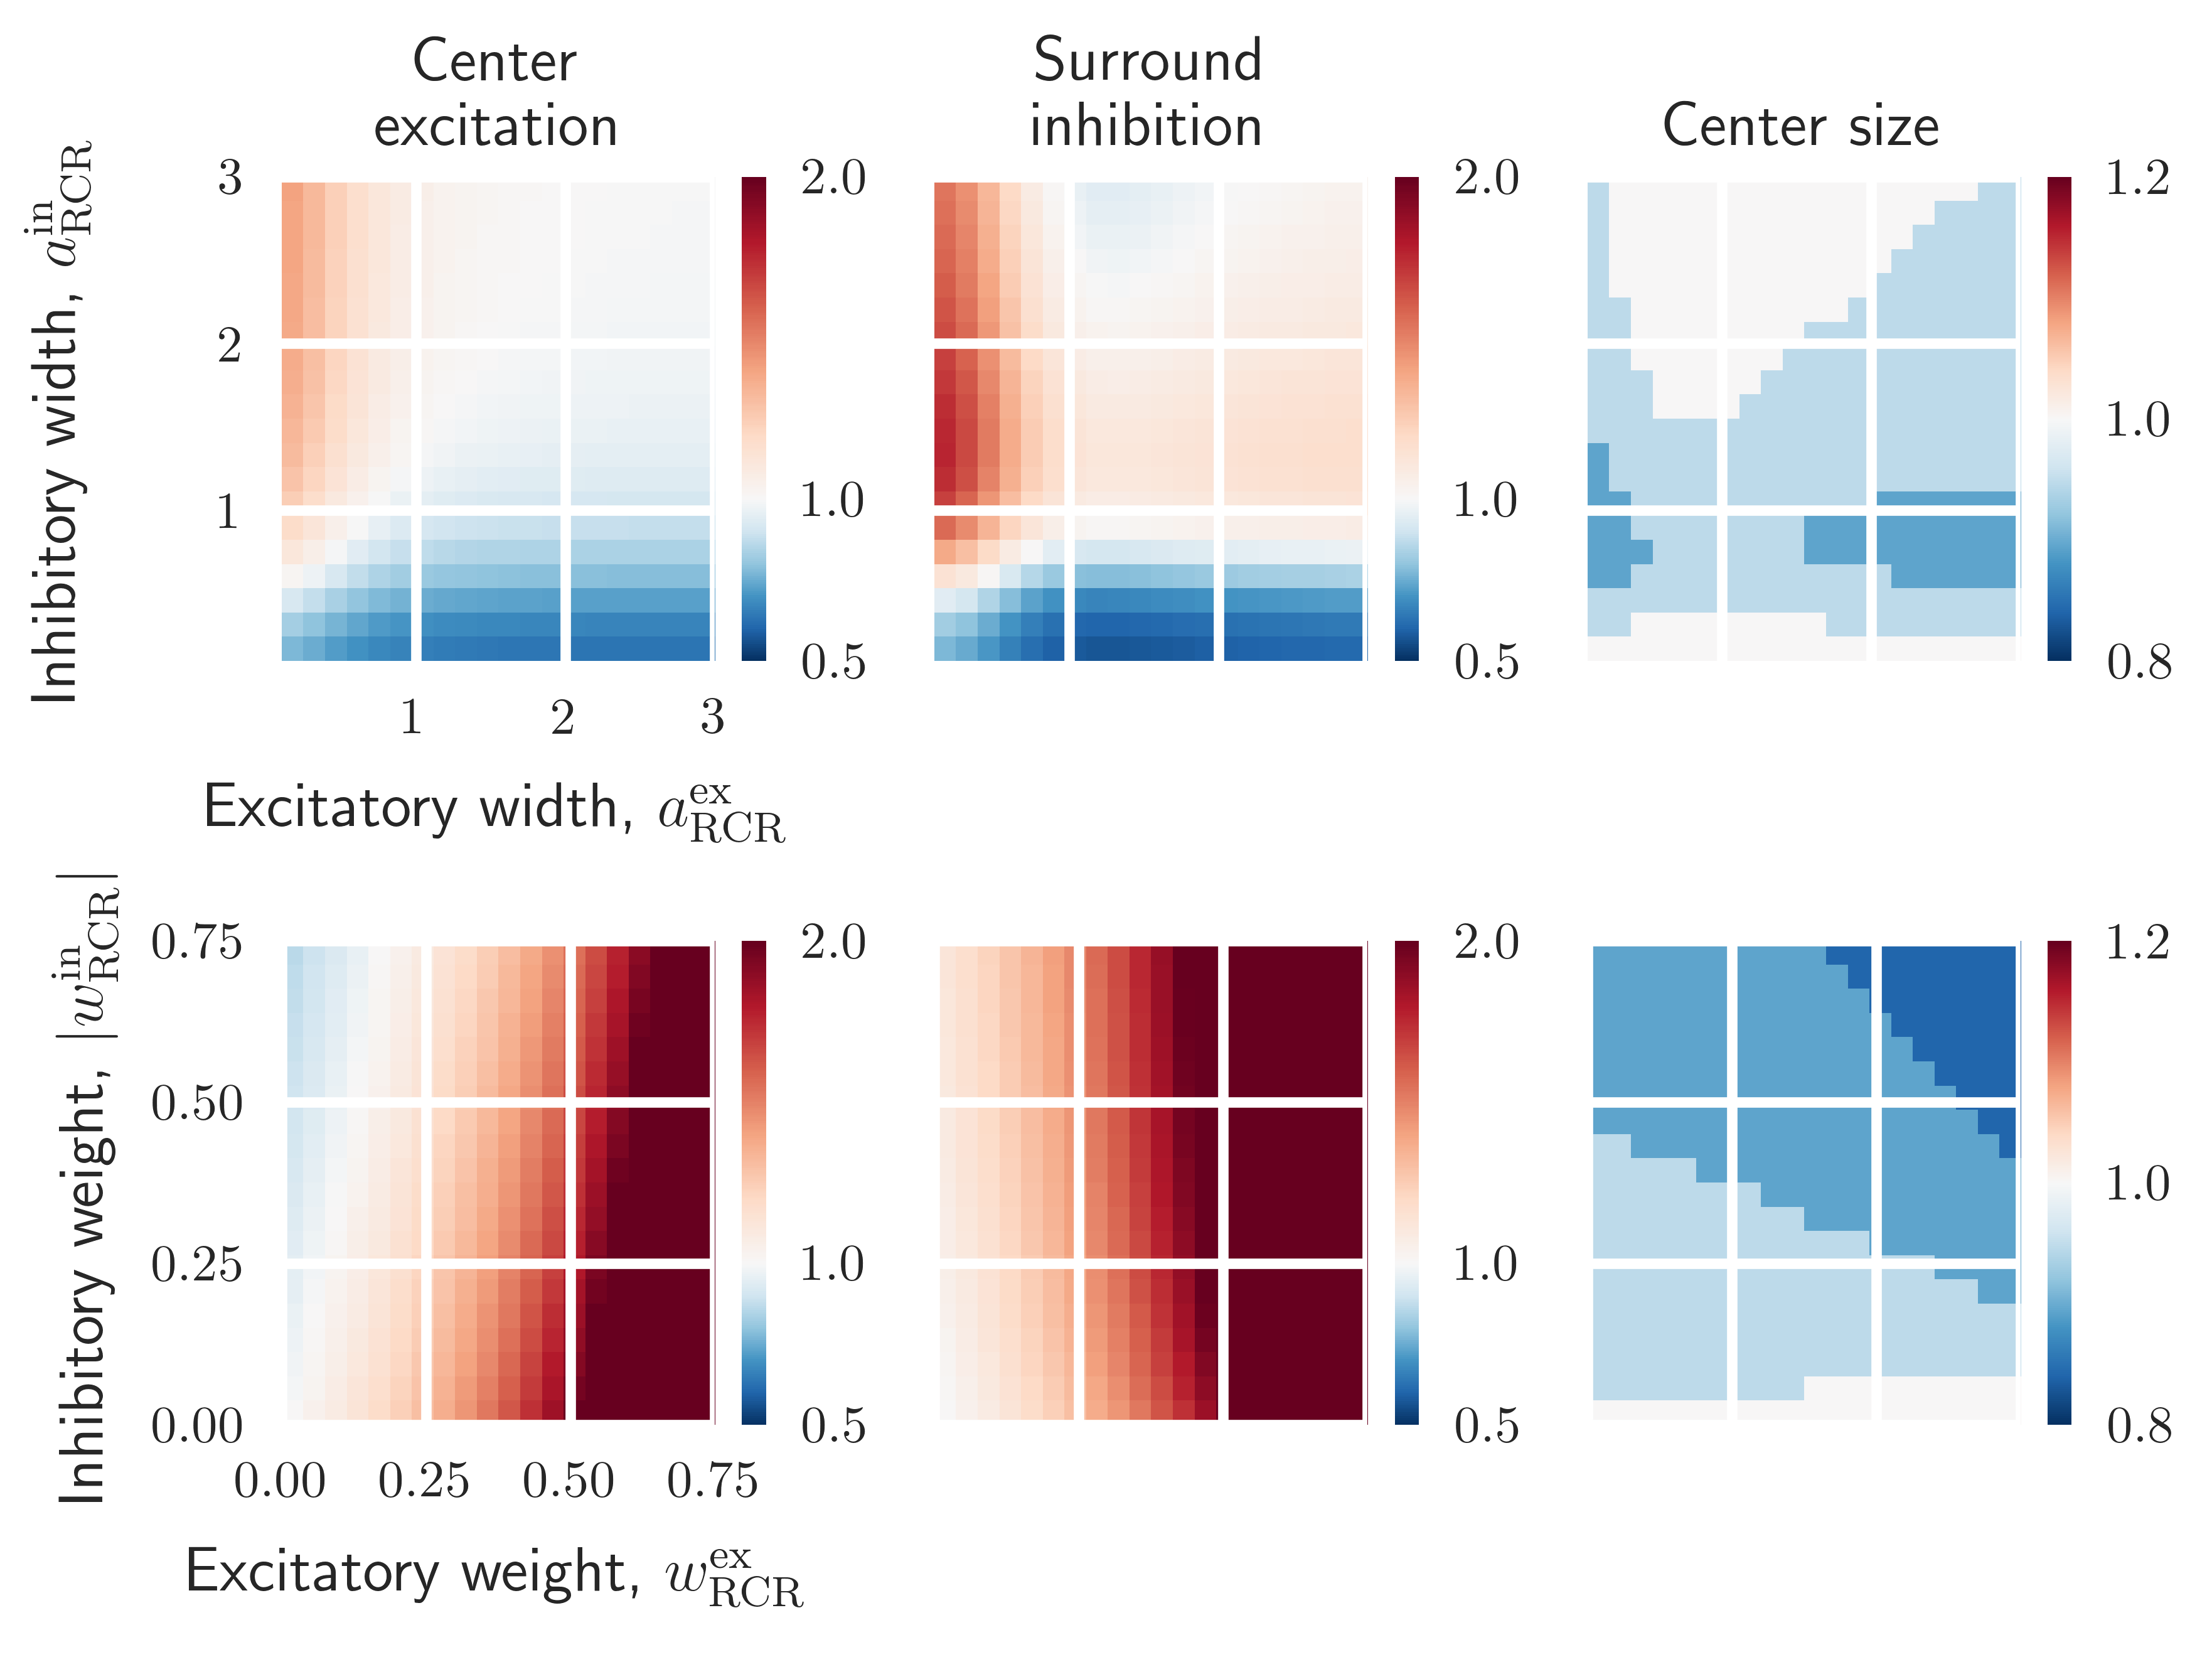

In [8]:
# Plot
cmap = "RdBu_r"
interpolation = "none"
titles = ["Center\nexcitation",
          "Surround\ninhibition",
          "Center size"]

cen_ex_vmin = 0.5
cen_ex_vmax = 2.0
sur_in_vmax = 2
sur_in_vmin = 0.5
cen_size_vmin = 0.8
cen_size_vmax = 1.2
weight_ticks = [0.0, 0.25, 0.5, 0.75]
width_ticks = [1, 2, 3]

fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(6, 4.5), sharey="row")

#plt.figtext(0.5, 0.83, "Feedback widths", ha='center', va='center', fontsize=16)
#plt.figtext(0.5, 0.43, "Feedback weights", ha='center', va='center', fontsize=16)


# ------------------------------------------------------------------------------------------------------------
# Feedback widths
# ------------------------------------------------------------------------------------------------------------
cen_ex = irf_data["widths"]["cen_ex"] / irf_data["ff_ex"]["cen_ex"]
sur_in = irf_data["widths"]["sur_in"] / irf_data["ff_ex"]["sur_in"]
cen_size = irf_data["widths"]["cen_size"] / irf_data["ff_ex"]["cen_size"]
extent = [a_rc_ex.min(), a_rc_ex.max(), a_rc_in.min(), a_rc_in.max()]

# center excitation
ax = axarr[0, 0]
im = ax.imshow(cen_ex, cmap=cmap,
               extent=extent, origin="lower",
               interpolation=interpolation, aspect="auto",
               vmin=cen_ex_vmin, vmax=cen_ex_vmax, norm=MidpointNormalize(midpoint=1.))

ax.set_xlabel("Excitatory width, $a^\mathrm{ex}_{\mathrm{RCR}}$", fontsize=12, labelpad=10)
ax.set_ylabel("Inhibitory width, $a^\mathrm{in}_{\mathrm{RCR}}$", fontsize=12, labelpad=22)
ax.set_title(titles[0], y=1.0)
plt.colorbar(im, ax=ax, ticks=[cen_ex_vmin, 1, cen_ex_vmax])
ax.grid(color="w", lw=2) 
ax.set_xticks(width_ticks)

# surround inhibition
ax = axarr[0, 1]
im = ax.imshow(sur_in, cmap=cmap,
               extent=extent, origin="lower",
               interpolation=interpolation, aspect="auto",
               vmin=sur_in_vmin, vmax=sur_in_vmax, norm=MidpointNormalize(midpoint=1.))

ax.set_title(titles[1], y=1.0)
plt.colorbar(im, ax=ax, ticks=[sur_in_vmin, 1, sur_in_vmax])
ax.grid(color="w", lw=2)
ax.xaxis.set_ticklabels([])

# center size
ax = axarr[0, 2]
im = ax.imshow(cen_size, cmap=cmap,
               extent=extent, origin="lower",
               interpolation=interpolation, aspect="auto",
               vmin=cen_size_vmin, vmax=cen_size_vmax, norm=MidpointNormalize(midpoint=1.))

ax.set_title(titles[2], y=1.0)
plt.colorbar(im, ax=ax, ticks=[cen_size_vmin, 1, cen_size_vmax])
ax.grid(color="w", lw=2) 
ax.xaxis.set_ticklabels([])

# ------------------------------------------------------------------------------------------------------------
# Feedback weights
# ------------------------------------------------------------------------------------------------------------
cen_ex = irf_data["weights"]["cen_ex"] / irf_data["ff_ex"]["cen_ex"]
sur_in = irf_data["weights"]["sur_in"] / irf_data["ff_ex"]["sur_in"]
cen_size = irf_data["weights"]["cen_size"] / irf_data["ff_ex"]["cen_size"]
extent = [A_rc_ex*w_rc_ex.min(), A_rc_ex*w_rc_ex.max(), 
          abs(A_rc_in)*w_rc_in.min(), abs(A_rc_in)*w_rc_in.max()]

# center excitation
ax = axarr[1, 0]
im = ax.imshow(cen_ex, cmap=cmap,
               extent=extent, origin="lower",
               interpolation=interpolation, aspect="auto",
               vmin=cen_ex_vmin, vmax=cen_ex_vmax, norm=MidpointNormalize(midpoint=1.))

ax.set_xlabel("Excitatory weight, $w^\mathrm{ex}_{\mathrm{RCR}}$", fontsize=12, labelpad=10)
ax.set_ylabel("Inhibitory weight, $|w^\mathrm{in}_{\mathrm{RCR}}|$", fontsize=12)
plt.colorbar(im, ax=ax, ticks=[cen_ex_vmin, 1, cen_ex_vmax])
ax.grid(color="w", lw=2) 
ax.set_xticks(weight_ticks)
ax.set_yticks(weight_ticks)

# surround inhibition
ax = axarr[1, 1]
im = ax.imshow(sur_in, cmap=cmap,
               extent=extent, origin="lower",
               interpolation=interpolation, aspect="auto",
               vmin=sur_in_vmin, vmax=sur_in_vmax, norm=MidpointNormalize(midpoint=1.))

plt.colorbar(im, ax=ax, ticks=[sur_in_vmin, 1, sur_in_vmax])
ax.grid(color="w", lw=2) 
ax.set_xticks(weight_ticks)
ax.set_yticks(weight_ticks)
ax.xaxis.set_ticklabels([])

# center size
ax = axarr[1, 2]
im = ax.imshow(cen_size, cmap=cmap,
               extent=extent, origin="lower",
               interpolation=interpolation, aspect="auto",
               vmin=cen_size_vmin, vmax=cen_size_vmax, norm=MidpointNormalize(midpoint=1.))

plt.colorbar(im, ax=ax, ticks=[cen_size_vmin, 1, cen_size_vmax])
ax.grid(color="w", lw=2) 
ax.set_xticks(weight_ticks)
ax.set_yticks(weight_ticks)
ax.xaxis.set_ticklabels([])

plt.tight_layout()